### **Cálculo de sensor acústico, siguiendo a Silanpaa et al.** 
#### **Evaluación del diseño para bajas frecuencias**
Obtenemos el valor de la masa de prueba usando los valores de referencia de Silanpaa et al. 2018.

In [140]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri

In [141]:
ro_si = 2329 # kg/m3
E = 130e+9 # GPa / N/m2
w = 28e-6 # µm
h = 25e-6 # µm
r_mass = 180e-6 # µm
m = np.pi * (r_mass**2) * h * ro_si
print('masa de prueba calculada =', format(m,'.2E'), 'kg')

masa de prueba calculada = 5.93E-09 kg


Con este dato obtenemos la longitud del resorte para una frecuencia de resonancia de 5 Hz. 

In [142]:
f = 5 #Hz
spring_l = ( (3 * E * w * (h **3)) / (4 * (np.pi**2) * (f**2) * m) ) ** (1./3)
print('longitud de viga para f0= 5 Hz : ',round(spring_l,2)*1e6, 'µm')

longitud de viga para f0= 5 Hz :  310000.0 µm


Este valor excede las dimensiones admisibles para un microdispositivo.

#### **Modelado de f0 en funcion de parametros dimensionales**


Estos autores obtienen la longitud de cada una de las 3 vigas que actúan como resortes de acuerdo a la siguiente ecuación:

$$ l= \sqrt[3]{\frac{3E w h^3}{4\pi^2 f_0^2 m}} $$

Reemplazando la masa $m$ por $\pi r^2 h \rho$, la misma puede reorganizarse para obtener la frecuencia de resonancia $f_0$ en función de todos los parámetros dimensionales del sensor:

$$ f_0^2 = {\frac{3E}{4\pi^3}} {\frac{h^2w}{r^2l^3}} $$

Para los valores de $h$ tomamos los espesores del device layer de las obleas SOI de uso más frecuente en microfabricación: 200 nm, 2.2 µm y 27.5 µm. Para los valores de ancho de viga $w$ tomamos un rango de valores de 1 a 100 µm, en tanto para la longitud de viga $l$ y radio de la masa de prueba $r$ tomamos el rango de 10 a 10000 µm (10 mm).

In [143]:
# Parámetros dimensionales del dispositivo
res= 500 # number of points
w = np.linspace(1e-6,100e-6,num=res) # 1-100 µm ancho de viga
l = np.linspace(10e-6,10000e-6,num=res) # 10-10000 µm de longitud de viga
H = np.array([200e-9,2.2e-6,27.5e-6]) # de 200 nm a 27.5 µm de espesor de Si (standard oblea SOI)
#H = np.array([2.2e-6]) 
r = np.linspace(10e-6,10000e-6,num=res) # 10-10000 µm de radio de masa de prueba

In [144]:
# Combinamos los parámetros dimensionales en un solo parámetro xdim0
xdim0= w / (r**2 * l**3)
xdim0[0], xdim0[-1]

(9.999999999999994e+18, 999999.9999999999)

In [145]:
# Vector invertido para graficar 
xdim=np.linspace(min(xdim0) , max(xdim0),num=res)
min(xdim), max(xdim)

(999999.9999999999, 9.999999999999994e+18)

2e-07  m .  5.00  Hz |  463772467.9666891 m^-4 form factor | index  108
2.2e-06  m .  5.00  Hz |  3824633.1612771987 m^-4 form factor | index  357
2.75e-05  m .  31.95  Hz |  999999.9999999999 m^-4 form factor | index  499


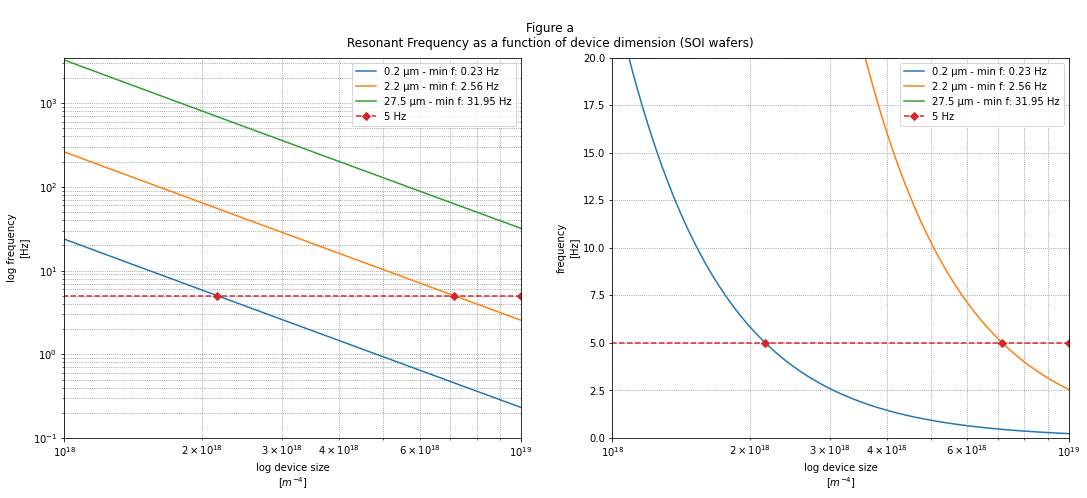

In [146]:
# Linea de referencia a 5 Hz
fref0=5.0
fref= np.empty(res)
fref.fill(fref0)

# Función para encontrar el punto de intersección con la línea de 5 Hz
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], xdim0[idx], idx

# Frecuecia de resonancia en función de los parámetros dimensionales combinados
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,7))
idxs=[]

for h in H:
    #fo2 = ( (3 * E) / (4 * np.pi**3 * ro_si) ) * ((w * h**2) / (r**2 * l**3))
    fo2 = ( (3 * E) / (4 * np.pi**3 * ro_si) ) * (xdim0 * h**2)
    #rangef = str(int(np.sqrt(min(fo2)))) + '-' + str(int(np.sqrt(max(fo2)))) + ' Hz'
    minf = str(np.round(h*1e6,3)) + ' µm' + ' - ' + 'min f: ' + str(np.round_(np.sqrt(min(fo2)),decimals=2)) + ' Hz'
    nearestf,nearestdim,pos= find_nearest(np.sqrt(fo2), fref0)
    idxs.append(pos)
    f = open(minf+'.txt', "w")
    np.savetxt(f, np.sqrt(fo2))
    f.close()
    print(h," m . ", "{:.2f}".format(nearestf)," Hz | ", nearestdim, "m^-4 form factor", "| index ", pos) #"{:.4e}".format(nearestdim) m\u2074 
    ax1.plot(xdim,np.sqrt(fo2), label=minf) #marker='D', 'D', markevery=pos,
    ax2.plot(xdim,np.sqrt(fo2), label=minf)
    
ax1.plot(xdim,fref, 'D', ls='--', markevery=idxs, label= '5 Hz')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('log device size\n''[$m^{-4}$]') # w * h^2 / r^2 * l^3
ax1.grid(True, which="both",ls=":", color='0.5')
ax1.set_ylabel('log frequency\n''[Hz]')
ax1.set_xlim([1e+18,max(xdim)])
ax1.set_ylim([.1,3500])
ax1.legend(loc='best')
#ax1 = plt.gca()  # only to illustrate what `ax` is
#ax1.autoscale(enable=True, axis='both', tight=True)

ax2.plot(xdim,fref, 'D', ls='--', markevery=idxs, label= '5 Hz')
ax2.set_xscale('log')
ax2.set_xlabel('log device size\n''[$m^{-4}$]') # w * h^2 / r^2 * l^3
ax2.set_ylabel('frequency\n''[Hz]')
ax2.grid(True, which="both",ls=":", color='0.5')

ax2.set_ylim([0,20])
ax2.set_xlim([1e+18,max(xdim)])
ax2.set_ylabel('frequency\n''[Hz]')
ax2.legend(loc='best')

fig.suptitle('\nFigure a\nResonant Frequency as a function of device dimension (SOI wafers)')

plt.show()

Evaluando el punto en que la curva de frecuencia intersecta la línea de 5 Hz, obtenemos el factor de forma mínimo para el cual un sensor con device layer de cada espesor cumple con dicha frecuencia de resonancia. Se toma ese valor de referencia como frecuencia central, asumiendo que existe un rango de frecuencias alrededor de esta en la cual el sensor podría tener comportamiento lineal. Para las obleas con device layer de 27.5 µm no existen valores de los parámetros dimensionales en el rango elegido que tengan frecuencias de resonancia $f_0$ por debajo de los 31.95 Hz (fuera del rango de la figura).

Tomando el factor de forma buscamos entonces todas las combinaciones de parámetros (radio de la masa de prueba, ancho de resorte y longitud de resorte) a través de las cuales es posible obtener esa frecuencia de resonancia.

In [147]:
margin = 1.000005
lower= 463772467 / margin
higher = 463772467 * margin

n=0
W, R, L, DIM=[],[],[],[]
for wi in w:
    for ri in r:
        for li in l:
            form_factor = (wi) / (ri**2 * li**3)
            if (form_factor >= lower) & (form_factor <= higher):
                W.append(wi); R.append(ri); L.append(li); DIM.append(form_factor)
                #print("{:.3e}".format(wi),",","{:.3e}".format(ri),",","{:.4e}".format(li),",","{:.2f}".format(form_factor))
                #outstring="{:.3e}".format(wi) + "," + "{:.3e}".format(ri) + "," + "{:.4e}".format(li) + "," + "{:.2f}".format(form_factor)+"\n"
                #print(outstring)
                n=n+1
print(n)

84


In [148]:
#save output to file 
np_w=np.array(W)
np.save("np_width", np_w)
np_r=np.array(R)
np.save("np_radius", np_r)
np_l=np.array(L)
np.save("np_length", np_l)
np_d=np.array(DIM)
np.save("np_dim", np_d)

In [149]:
# If restored from previus session, use data file
W=np.load("np_width.npy")
R=np.load("np_radius.npy")
L=np.load("np_length.npy")
DIM=np.load("np_dim.npy")

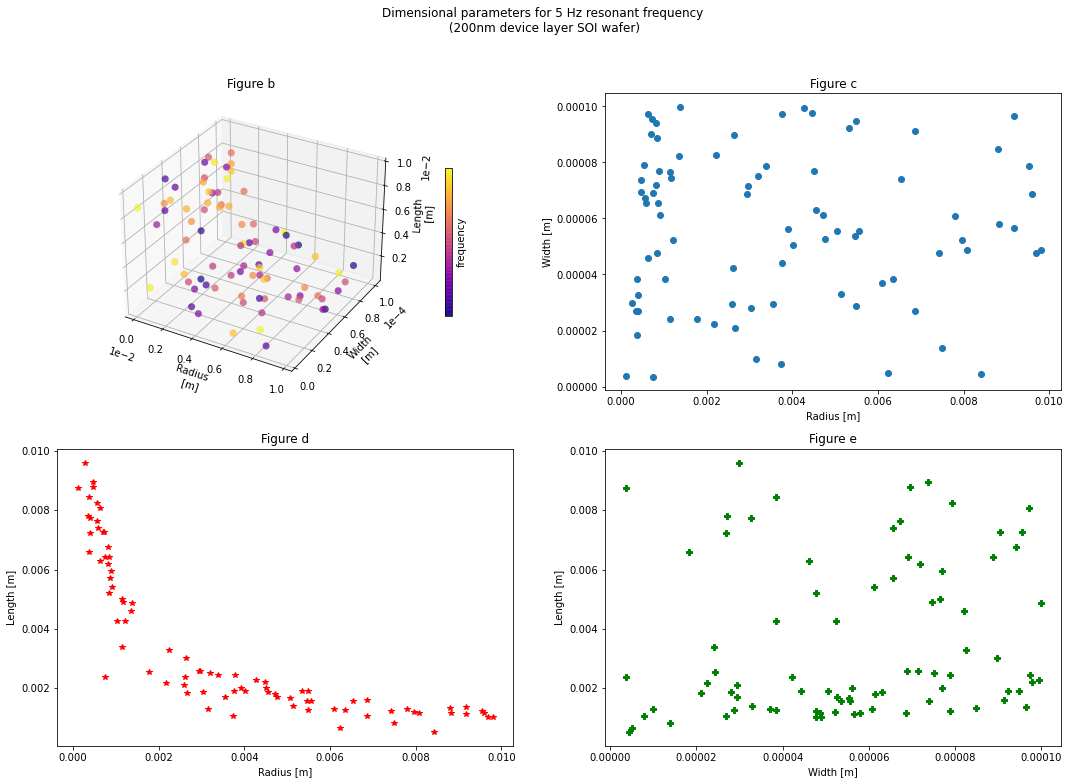

In [150]:
fig = plt.figure(figsize=(18,12))
fig.suptitle('Dimensional parameters for 5 Hz resonant frequency\n (200nm device layer SOI wafer)')

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
f_scale = (( (3 * E) / (4 * np.pi**3 * ro_si) ) * (DIM * 200e-9**2))**(1/2.)
p= ax1.scatter(R, W, L,
           linewidths=.1, alpha=.7,
           edgecolor='y',
           s = 50,
           c=f_scale,
            cmap='plasma')

cbar = fig.colorbar(p, ax=ax1, shrink=0.5, pad=0.1, label="frequency")
cbar.set_ticks([])
ax1.set_xlabel('Radius\n [m]')
ax1.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax1.set_ylabel('Width\n [m]')
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1.set_zlabel('Length\n [m]')
ax1.ticklabel_format(axis="z", style="sci", scilimits=(0,0))
ax1.set_title('Figure b')

ax5 = fig.add_subplot(2, 2, 2)
ax5.plot(R, W, 'o')
ax5.set_xlabel('Radius [m]')
ax5.set_ylabel('Width [m]')
ax5.set_title('Figure c')

ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(R, L, 'r*')
ax3.set_xlabel('Radius [m]')
ax3.set_ylabel('Length [m]')
ax3.set_title('Figure d')

ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(W, L, 'gP')
ax4.set_xlabel('Width [m]')
ax4.set_ylabel('Length [m]')
ax4.set_title('Figure e')

plt.show()

En la figura a pueden verse las combinaciones dimensionales que dan como resultado una frecuencia de resonancia de 5 Hz ±.0005%. La escala de colores da cuenta del grado de desviación de esta frecuencia central. Las figuras b, c y d muestran la relación entre los pares de variables.

Text(0.5, 0.92, 'Figure e')

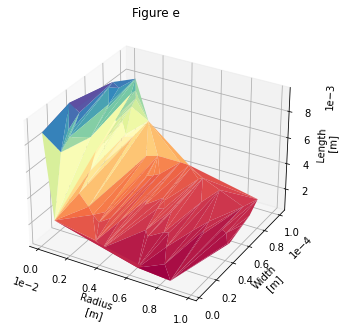

In [151]:
fig = plt.figure(figsize=(18,12))
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
tri = mtri.Triangulation(R, W)
surf= ax2.plot_trisurf(R,W,L,triangles=tri.triangles,cmap=plt.cm.Spectral)
ax2.set_xlabel('Radius\n [m]')
ax2.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax2.set_ylabel('Width\n [m]')
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax2.set_zlabel('Length\n [m]')
ax2.ticklabel_format(axis="z", style="sci", scilimits=(0,0))
ax2.set_title('Figure e')

En la figura e este conjunto de datos se representa como superficie, donde la escala de color representa la longitud del resorte, parámetro de mayor relevancia en el diseño. Como es esperable, el ancho de resorte reviste el menor impacto en la respuesta del sensor. El valor central de este conjunto representa un compromiso en los parámetros dimensionales, a partir del cual explorar el diseño por la técnica de elementos finitos.

In [152]:
print("Median device dimensions for 5 Hz resonant frequency\n",
      "{:.3e}".format(np.median(R)), "m proof-mass radius\n",
      "{:.3e}".format(np.median(W)),"m spring width\n",
      "{:.3e}".format(np.median(L)),"m spring length")

Median device dimensions for 5 Hz resonant frequency
 3.093e-03 m proof-mass radius
 5.635e-05 m spring width
 2.232e-03 m spring length
